## **Notebook Setup**

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FastICA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.decomposition import FactorAnalysis

from sklearn.manifold import TSNE
from sklearn.manifold import Isomap

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

### **Utility Functions**

1. `plot_gallery` function can be used to visulize the given input image.
2. `visualize_features` function can be used to plot column vectors of 2 different representation methods.

In [31]:
# function to view the images in n_col x n_row gallery view
def plot_gallery(title:str, images, n_col=3, n_row=2, cmap=plt.cm.gray):
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.0 * n_col, 2.88 * n_row),
        facecolor="white",
        constrained_layout=True,
    )

    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.01, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title)
    # display images in a n_col x n_row subplots
    for ax, vec in zip(axs.flat, images):
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec.reshape((HEIGHT, WIDTH)),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")

    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.show()

# function to plot column vectors of two representation methods side by side
def visualize_features(c1:list, c2:list, pc1:list, pc2:list, y:list, method:str=''):
  fig, axes = plt.subplots(1, 2, figsize=(9, 4.5))
  fig.suptitle('Projection of data using ' + method)

  sns.scatterplot(ax=axes[0], x=c1, y=c2, hue=y,  **{'alpha': 0.6}, palette='tab10')
  axes[0].set_xlabel("Feature 1")
  axes[0].set_ylabel("Feature 2")

  sns.scatterplot(ax=axes[1], x=pc1, y=pc2, hue=y,  **{'alpha': 0.6}, legend=0, palette='tab10')
  axes[1].set_xlabel("Principal Component 1")
  axes[1].set_ylabel("Principal Component 2")

  fig.tight_layout()
  plt.show()

## **Load the LFW Data**

**About the Dataset:** 

  Labeled Faces in the Wild is a database of face photographs designed for studying the problem of unconstrained face recognition. The data set contains more than 13,000 images of faces collected from the web. Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set.

**Link:** [Labeled Faces in the Wild](https://vis-www.cs.umass.edu/lfw/)

In [22]:
MIN_CLASS_SIZE = 120

# fetch classes with minimum size of 120 and resize to 80%
lfw_people = fetch_lfw_people(min_faces_per_person=MIN_CLASS_SIZE, resize=0.8)

X = lfw_people.data
y = lfw_people.target

_, HEIGHT, WIDTH = lfw_people.images.shape
CLASS_NAMES = lfw_people.target_names

index = []

# resample the data to address class imbalance
for i in range(len(CLASS_NAMES)):
  arr = np.where(y==i)[0]
  if len(arr) > MIN_CLASS_SIZE*1.5:
    index += list(np.random.choice(np.where(y==i)[0], 
                                   MIN_CLASS_SIZE + np.random.randint(MIN_CLASS_SIZE*0.5), 
                                   replace=False))
  else:
    index += list(np.random.choice(np.where(y==i)[0], 
                                   len(arr), 
                                   replace=False))

X = X[index]
y = y[index]

print('LFW Data Loaded Succesfully\n')
print('No. of Samples : ', len(y))
print('Image Size     : ', HEIGHT, "x", WIDTH)
print('No. of Classes : ', len(CLASS_NAMES))
print('Class Names    : ', " ,".join(CLASS_NAMES))

LFW Data Loaded Succesfully

No. of Samples :  612
Image Size     :  100 x 75
No. of Classes :  4
Class Names    :  Colin Powell,Donald Rumsfeld,George W Bush,Tony Blair


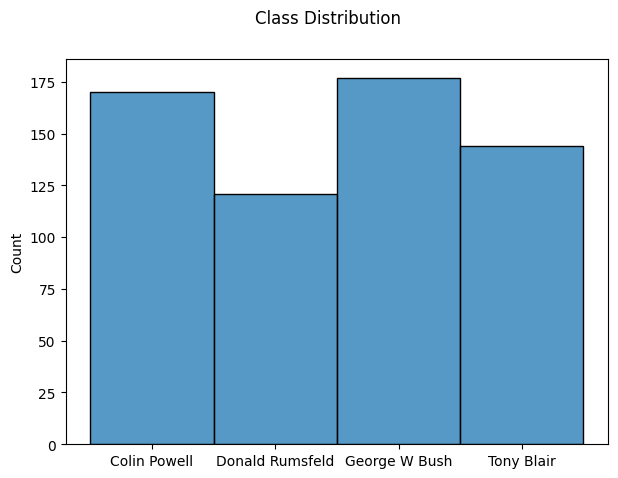

In [23]:
# visualize the class distribution
fig, axes = plt.subplots(figsize=(7, 5))
axes = sns.histplot([CLASS_NAMES[i] for i in y])
fig.suptitle('Class Distribution')

plt.show()

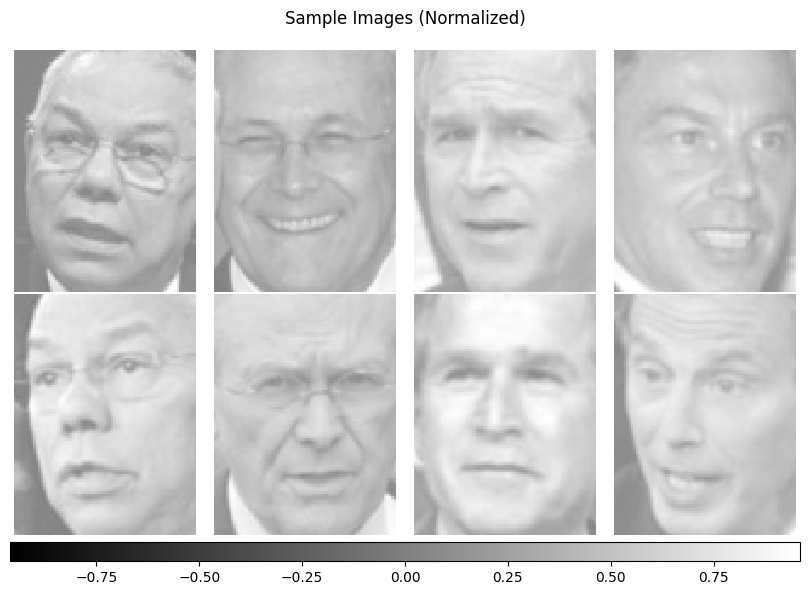

In [26]:
# display sample images
idx = np.asarray([np.random.choice(np.where(y==i)[0], 1, replace=False) for i in range(len(CLASS_NAMES))]
                 +[np.random.choice(np.where(y==i)[0], 1, replace=False) for i in range(len(CLASS_NAMES))]
                 ).flatten()
                 
plot_gallery("Sample Images (Normalized)\n", X[idx], n_col=4)

## **Data Representation**

Data representation is an essential aspect of machine learning as it plays a crucial role in the performance of the classification models. The goal of data representation is to transform the input data into a more informative and compact representation. The following data representation methods are evaluated to determine their effectiveness in improving the performance of multiple nonlinear classifier on the LFW dataset.

**Methods Used:**
- PCA
- kPCA
- FactorAnalysis
- Isomap
- FastICA

In [42]:
N_COMP = 50

# initialize data representation methods
pca    = PCA(n_components=N_COMP, svd_solver="randomized", whiten=True)
kpca   = KernelPCA(n_components=N_COMP)
fa     = FactorAnalysis(n_components=N_COMP, max_iter=20)
isomap = Isomap(n_components=N_COMP)
ica    = FastICA(n_components=N_COMP, whiten='unit-variance')

methods = [pca, kpca, fa, ica, isomap]

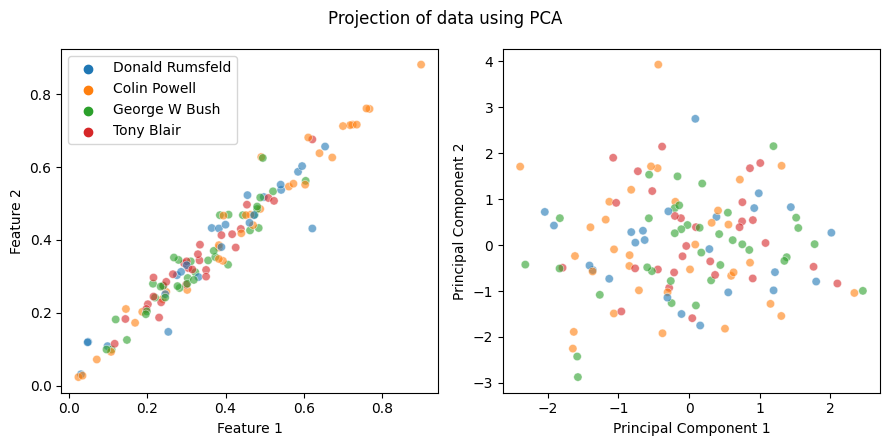

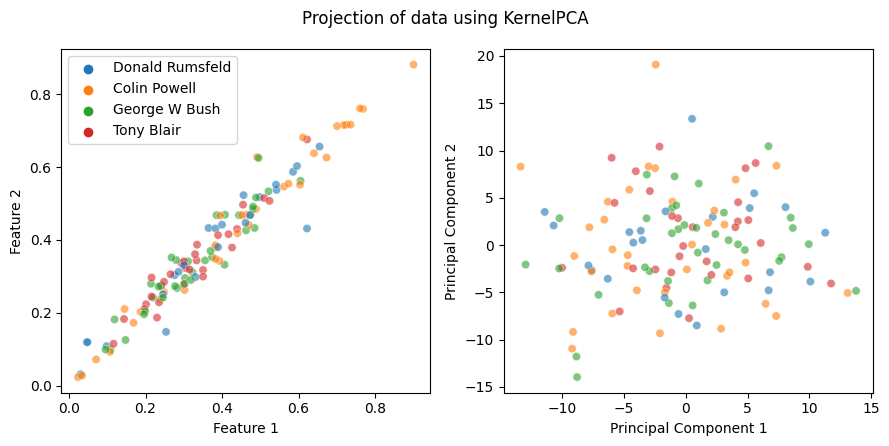

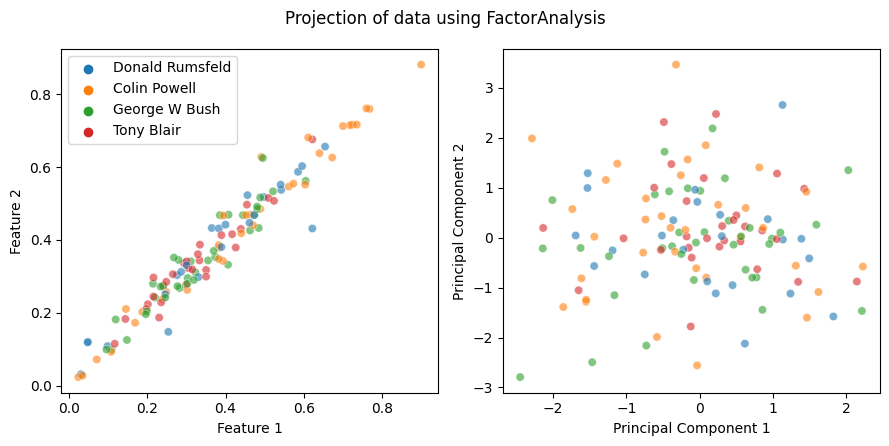

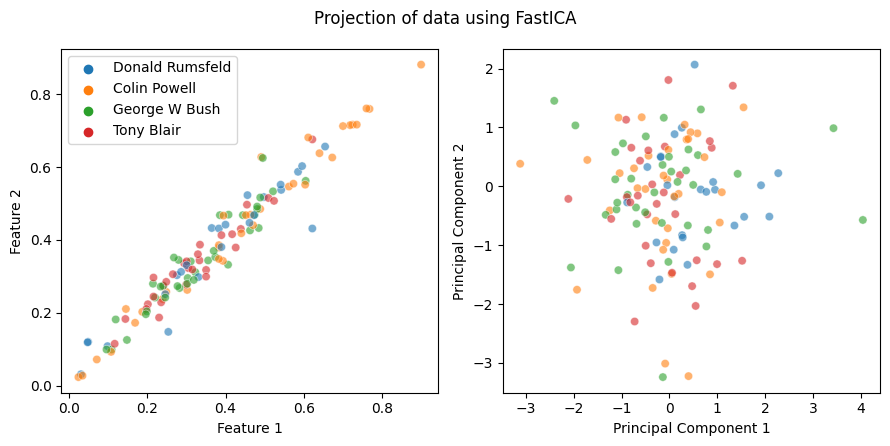

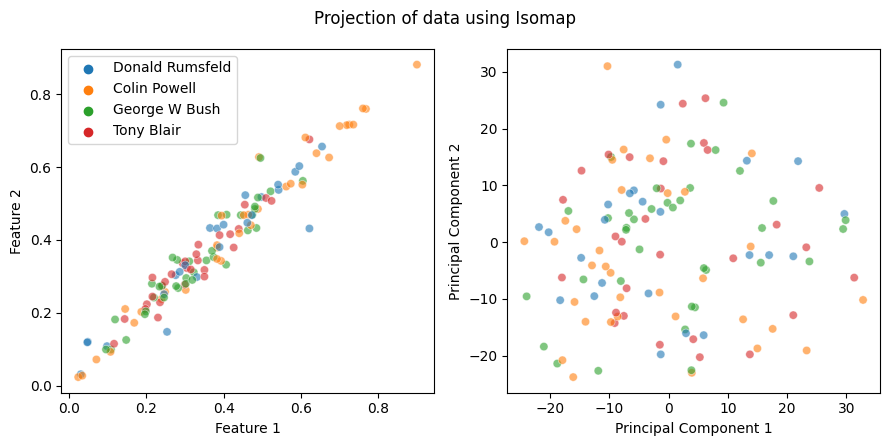

In [43]:
# prepare the training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y, 
                                                    random_state=42, 
                                                    test_size=0.2)

X_transformed = []
cmap = [CLASS_NAMES[j] for j in y_test]

for i in methods:
  X_train_rep = i.fit_transform(X_train)
  X_test_rep = i.fit(X_train).transform(X_test)

  # plot project of the representation method
  visualize_features(X_test[:, 0], X_test[:, 1], 
                     X_test_rep[:, 0], X_test_rep[:, 1], 
                     cmap, 
                     i.__class__.__name__)

  # save the transformed data for later use
  X_transformed.append({
      'method': i.__class__.__name__,
      'train': X_train_rep,
      'test': X_test_rep
  })

## **Evaluate Representation Methods**

The effectiveness of different data representation methods is evaluated using two non-linear classifiers: SVM and kNN. Accuracy and F1 score are the metrics used to assess the performance of each representation method. The goal is to determine which representation method performs best when used with these classifiers, and how accurately it can predict the target variable.

#### **1. Support Vector Classifier (kSVM)**

In [57]:
# find best parameters for svc
param_grid = {
         'C': [1e3, 5e3],
          'gamma': [0.0001, 0.0005, 0.001],
          'kernel': ['poly', 'rbf', 'sigmoid']
          }

clf_svc = GridSearchCV(SVC(class_weight='balanced'), 
                   param_grid, 
                   cv=10)
clf_svc = clf_svc.fit(X_train, y_train)

print("Best params using GridSearch:\n", clf_svc.best_params_)
print("Train Accuracy :  {:.2f}%".format(clf_svc.best_score_*100) )

Best params using GridSearch:
 {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Train Accuracy :  87.72%


In [61]:
svc_results = []
# train using raw data
svc_raw = make_pipeline(StandardScaler(), 
                    SVC(**clf_svc.best_params_))
svc_raw.fit(X_train, y_train)

# make prediction on raw test data
y_pred = svc_raw.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
clf_report = classification_report(y_test, y_pred, zero_division=0)

print("Method: Raw data\n")
print("Accuracy   : {:.2f}%".format(accuracy*100))
print("F1 Score   : {:.4f}".format(f1))
print("\nClassification Report:\n\n", clf_report)

# save results
svc_results.append({
    'method': 'Raw Data',
    'accuracy': accuracy,
    'f1': f1
})

Method: Raw data

Accuracy   : 41.46%
F1 Score   : 0.3025

Classification Report:

               precision    recall  f1-score   support

           0       0.63      0.35      0.45        34
           1       0.00      0.00      0.00        24
           2       0.35      0.97      0.51        36
           3       1.00      0.14      0.24        29

    accuracy                           0.41       123
   macro avg       0.50      0.37      0.30       123
weighted avg       0.51      0.41      0.33       123



In [62]:
# train and evaluate all representation methods
for i in X_transformed:
  svc = make_pipeline(StandardScaler(), 
                    SVC(kernel="rbf", 
                        class_weight='balanced'))
  svc.fit(i['train'], y_train)

  # make prediction on test data
  y_pred = svc.predict(i['test'])

  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average='macro')
  
  print("Method: ", i['method'])
  print("Accuracy   : {:.2f}%".format(accuracy*100))
  print("F1 Score   : {:.4f}".format(f1))
  print("-"*60)

  # save results
  svc_results.append({
    'method': i['method'],
    'accuracy': accuracy,
    'f1': f1
})

Method:  PCA
Accuracy   : 86.99%
F1 Score   : 0.8680
------------------------------------------------------------
Method:  KernelPCA
Accuracy   : 90.24%
F1 Score   : 0.8999
------------------------------------------------------------
Method:  FactorAnalysis
Accuracy   : 92.68%
F1 Score   : 0.9267
------------------------------------------------------------
Method:  FastICA
Accuracy   : 21.95%
F1 Score   : 0.2098
------------------------------------------------------------
Method:  Isomap
Accuracy   : 48.78%
F1 Score   : 0.4841
------------------------------------------------------------


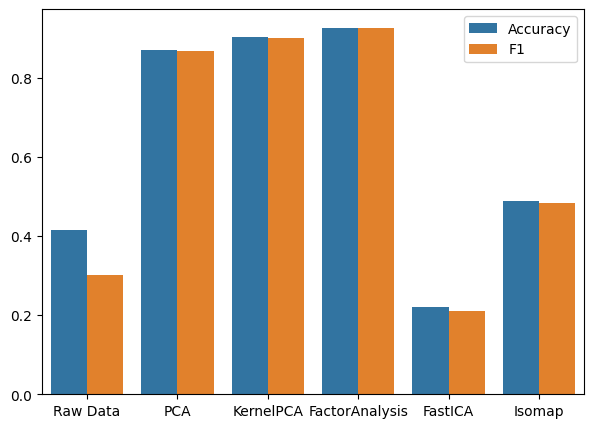

In [63]:
# visualize performance of each approach
met = [i['method'] for i in svc_results] * 2
acc = [i['accuracy']for i in svc_results]
f1s = [i['f1']for i in svc_results]

metrics = acc + f1s
hue = ['Accuracy'] * len(acc) + ['F1'] * len(f1s)

fig, axes = plt.subplots(figsize=(7, 5))
axes = sns.barplot(x=met, y=metrics, hue=hue, palette='tab10')

plt.show()

#### **2. K-nearest Neighbor Classifier (kNN)**

In [70]:
# find best parameters for knn
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

clf_knn = GridSearchCV(KNeighborsClassifier(), 
                   param_grid, 
                   scoring='accuracy',
                   cv=10)
clf_knn = clf_knn.fit(X_train, y_train)

print("Best params using GridSearch:\n", clf_knn.best_params_)
print("Train Accuracy :  {:.2f}%".format(clf_knn.best_score_*100) )

Best params using GridSearch:
 {'n_neighbors': 18}
Train Accuracy :  58.90%


In [71]:
knn_results = []
# train using raw data
knn_raw = KNeighborsClassifier(**clf_knn.best_params_)
knn_raw.fit(X_train, y_train)

# make prediction on raw test data
y_pred = knn_raw.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
clf_report = classification_report(y_test, y_pred, zero_division=0)

print("Method: Raw data\n")
print("Accuracy   : {:.2f}%".format(accuracy*100))
print("F1 Score   : {:.4f}".format(f1))
print("\nClassification Report:\n\n", clf_report)

# save results
knn_results.append({
    'method': 'Raw Data',
    'accuracy': accuracy,
    'f1': f1
})

Method: Raw data

Accuracy   : 56.10%
F1 Score   : 0.5373

Classification Report:

               precision    recall  f1-score   support

           0       0.49      0.76      0.60        34
           1       0.62      0.33      0.43        24
           2       0.64      0.64      0.64        36
           3       0.57      0.41      0.48        29

    accuracy                           0.56       123
   macro avg       0.58      0.54      0.54       123
weighted avg       0.58      0.56      0.55       123



In [72]:
# train and evaluate all representation methods
for i in X_transformed:
  knn = KNeighborsClassifier(**clf_knn.best_params_)
  knn.fit(i['train'], y_train)

  # make prediction on test data
  y_pred = knn.predict(i['test'])

  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average='macro')
  
  print("Method: ", i['method'])
  print("Accuracy   : {:.2f}%".format(accuracy*100))
  print("F1 Score   : {:.4f}".format(f1))
  print("-"*60)

  # save results
  knn_results.append({
    'method': i['method'],
    'accuracy': accuracy,
    'f1': f1
})

Method:  PCA
Accuracy   : 72.36%
F1 Score   : 0.7180
------------------------------------------------------------
Method:  KernelPCA
Accuracy   : 57.72%
F1 Score   : 0.5629
------------------------------------------------------------
Method:  FactorAnalysis
Accuracy   : 83.74%
F1 Score   : 0.8304
------------------------------------------------------------
Method:  FastICA
Accuracy   : 19.51%
F1 Score   : 0.1854
------------------------------------------------------------
Method:  Isomap
Accuracy   : 42.28%
F1 Score   : 0.3887
------------------------------------------------------------


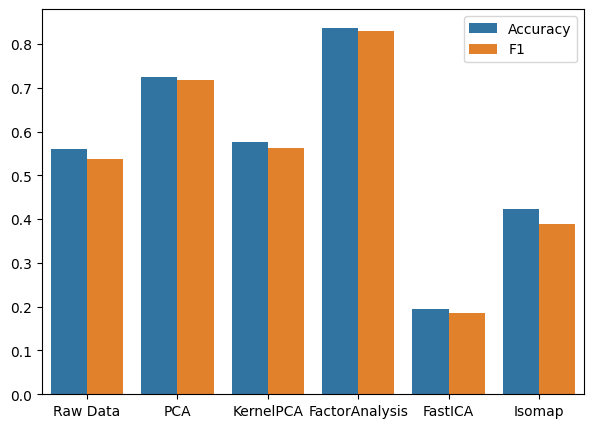

In [73]:
# visualize performance of each approach
met = [i['method'] for i in knn_results] * 2
acc = [i['accuracy']for i in knn_results]
f1s = [i['f1']for i in knn_results]

metrics = acc + f1s
hue = ['Accuracy'] * len(acc) + ['F1'] * len(f1s)

fig, axes = plt.subplots(figsize=(7, 5))
axes = sns.barplot(x=met, y=metrics, hue=hue, palette='tab10')

plt.show()

---

## **Appendix: Eigenfaces**

**What are Eigenfaces?**

- Eigenfaces are a set of eigenvectors derived from the covariance matrix of a 
set of face images. In simpler terms, eigenfaces are a mathematical representation of facial features that can be used to recognize and classify faces.

**Importance:**
- Eigenfaces have numerous applications in computer vision and pattern recognition. One of the most important applications is face recognition, which involves identifying individuals based on their facial features. Eigenfaces can be used to create a template for each individual based on their facial characteristics, which can then be compared to other templates in order to identify the person. This technique has been used in security systems, law enforcement, and other areas where identification is important.
- In addition to face recognition, eigenfaces have also been used in other areas such as image compression, where they can be used to reduce the amount of data required to represent an image. This makes it easier to store and transmit images over networks, and can also reduce the computational load required for image processing.


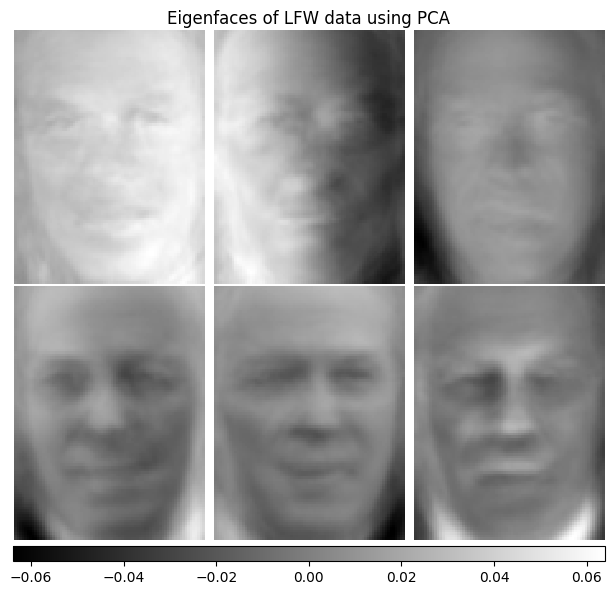

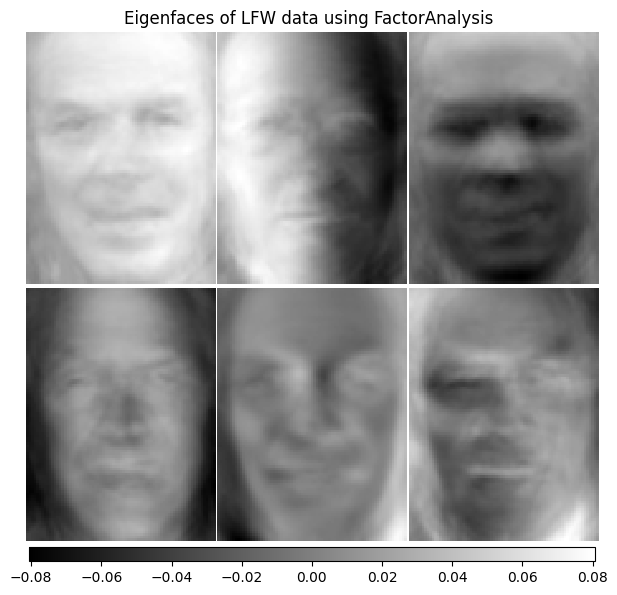

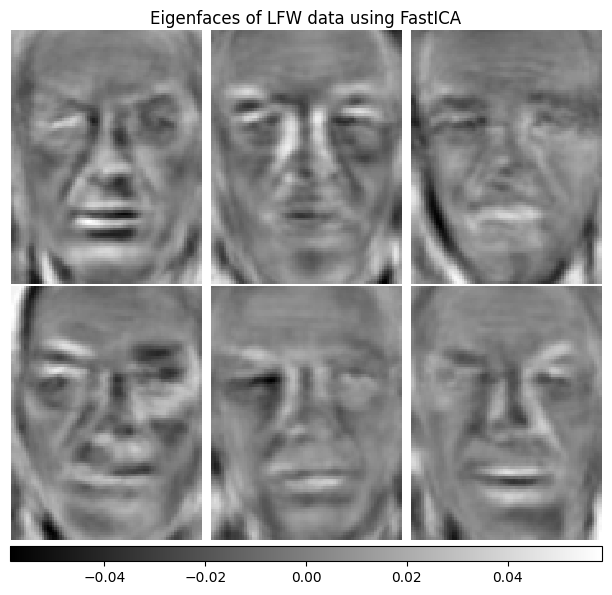

In [77]:
for i in [pca, fa, ica]:
  obj = i.fit(X)

  # plot eigenface using eigenvectors 
  plot_gallery("Eigenfaces of LFW data using " + i.__class__.__name__, 
               obj.components_[:N_COMP])